In [47]:
from scipy.stats import norm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import warnings
warnings.filterwarnings("ignore")
import io

# (1) Preliminary EDA: Total Dataset

Our population of interest for the models discussed herein is the combined set of `Fully Paid` and `Charged Off` borrowers. Lending club defines these categories as follows:

`Charged Off` = A loan that has no reasonable expectation of further payments.

`Fully Paid` = A loan that has fully repaid the principal, plus any interest payments per the agreed interest rate.


To explore the data and train our models, we examine the 2016 Q1 Lending Club data set, with only observations classified as `Fully Paid` and `Charged Off` included. The data set contains 60,430 "Fully Paid" observations and 21,114 "Charged Off" observations, for a total of 81,544 observations.

This section focuses on understanding some basic distributional properties of the lending club dataset.

In [48]:
# Total dataframe with 81,544 observatins from Q1 2016. 
# 60,430 Fully Paid observations and 21,114 Charged Off observations
master = pd.read_csv('LC2016Q1_v2_copy.csv', skiprows=0)
master = master.sample(frac=0.1)

In [49]:
race = pd.read_csv('zip_proportions_correct.csv')
race = race.drop("Unnamed: 0",axis=1)

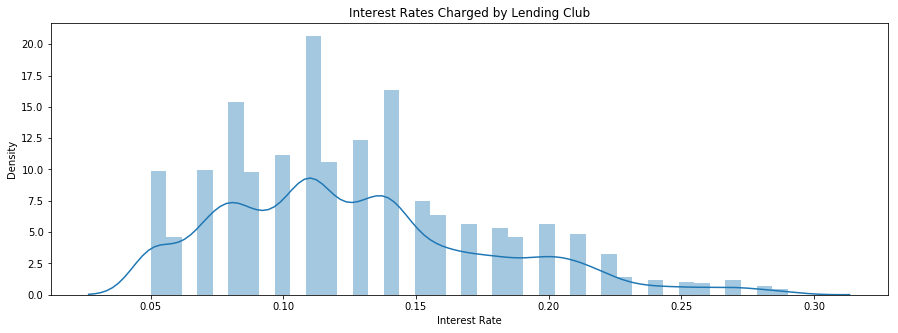

In [50]:
warnings.simplefilter(action='ignore', category=FutureWarning)

f, ax = plt.subplots(1,1,figsize=(15,5)) 
fig = sns.distplot(master["int_rate"],norm_hist=True)
plt.xlabel("Interest Rate")
plt.ylabel('Density')
plt.title("Interest Rates Charged by Lending Club")
plt.show(fig)

In [51]:
np.mean(master['int_rate']), np.min(master['int_rate']), np.max(master['int_rate'])

(0.12703458425312952, 0.05, 0.29)

The mean interest rate for this dataset is 12.75%, though it ranges from a minimum of 5% to a maximum of 29%.

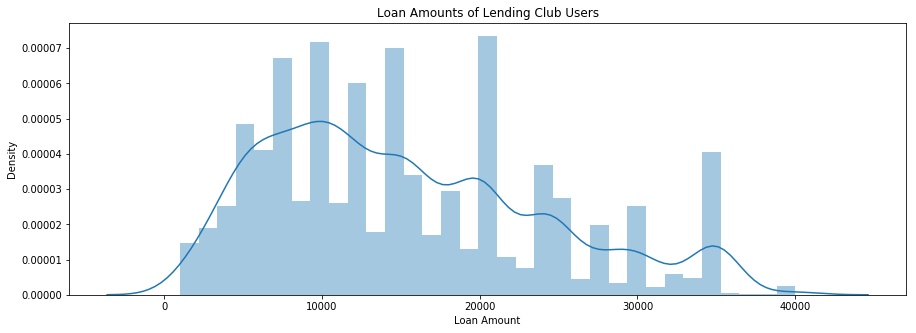

In [52]:
f, ax = plt.subplots(1,1,figsize=(15,5)) 
fig = sns.distplot(master["loan_amnt"],norm_hist=True)
plt.xlabel("Loan Amount")
plt.ylabel('Density')
plt.title("Loan Amounts of Lending Club Users")
plt.show(fig)

In [7]:
np.mean(master['loan_amnt']), np.min(master['loan_amnt']), np.max(master['loan_amnt'])

(15315.707014961981, 1000, 40000)

The mean requested loan amount for this dataset is $\$$15,325, though it ranges from a minimum of $\$$1000 to a maximum of $\$$40,000.

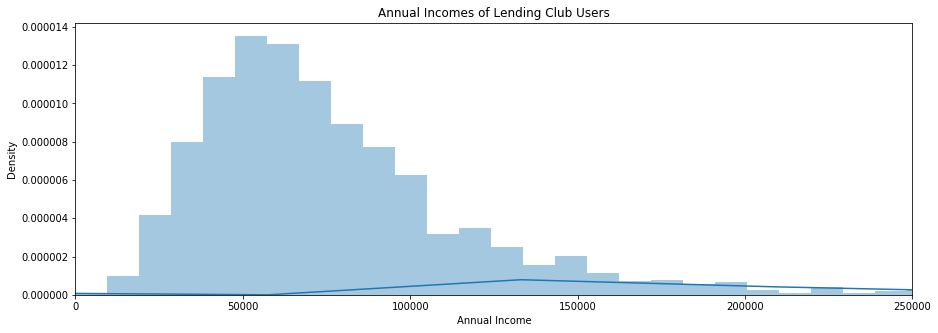

In [53]:
f, ax = plt.subplots(1,1,figsize=(15,5)) 
fig = sns.distplot(master["annual_inc"],bins=1000,norm_hist=True)
plt.xlim(0,250000)
plt.xlabel("Annual Income")
plt.ylabel('Density')
plt.title("Annual Incomes of Lending Club Users")
plt.show(fig)

In [9]:
np.mean(master['annual_inc']), np.median(master['annual_inc'])

(79505.07938557764, 68000.0)

The mean income of a lending club applicant for this dataset is $\$$79,249, though this mean is upwardly biased by an extremely right-skewed distribution of applicant incomes. The median income is $\$$68,000.

# (2) Investing Deepdive: Fully Paid vs. Charged Off

From the perspective of the lender, the response variable of interest here is whether a borrower will fully pay his or her loan, or have it considered "charged off". Lending Club assigns interest rates according to subgrades, which they choose and which borrowers (and lenders) have no say over. Hence, for a given interest rate, the only "edge" an investor can obtain is ascertaining the probability that a borrower fully pays back his loan. This is what our models will focus on.

As a result, the most illustrative data analysis comes in outlining the differences between the `fully paid` and `charged off` classes. Our models will exploit these differences to learn which loans are "good" (i.e. will pay fully) and which loans are "bad" (i.e. will be charged off).

In [54]:
fp_num = sum(master['loan_status'] == 'Fully Paid')
cf_num = sum(master['loan_status'] == 'Charged Off')

fp_prop = fp_num/len(master)
cf_prop = cf_num/len(master)

fp_cf_list = [fp_prop, cf_prop]

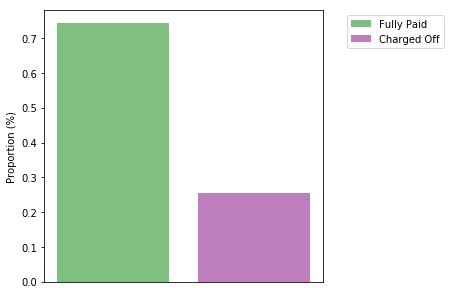

In [55]:
f = plt.figure(figsize=(5,5))

plt.bar('Loan Status',fp_prop, color = 'green', alpha=0.5)
plt.bar('Loan Status 2',cf_prop, color = 'purple', alpha=0.5)
plt.ylabel('Proportion (%)')

plt.legend(['Fully Paid', 'Charged Off'],bbox_to_anchor=(1.45, 1))

frame = plt.gca()

frame.axes.get_xaxis().set_ticks([])
# frame.axes.get_yaxis().set_ticks([])

plt.show()

Our dataset contains 74.1$\%$ `fully paid` observations and 25.9$\%$ `charged off` observations. The accuracy of our models should be interpreted in this context; any good model must, at minimum, perform better than 74.1$\%$ accuracy on this data - that is, better than a strategy of picking the most frequent result. 

In [56]:
# Dataset of 40,000 observations, with 20,0000 from 
df = pd.read_csv('EDA_sample.csv')

In [57]:
for i in df['revol_util'].index:
    if pd.isnull(df['revol_util'][i]):
        df.iloc[i,21] = '0'
        
df['revol_util'] = df['revol_util'].apply(lambda x: x.strip('%'))

In [58]:
fp = df[df['loan_status'] == 'Fully Paid']
cf = df[df['loan_status'] == 'Charged Off']

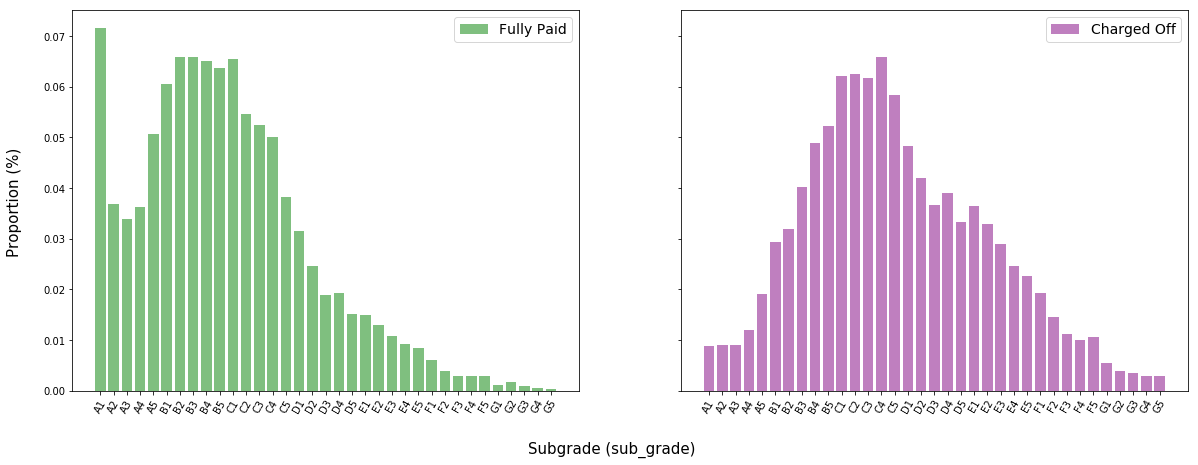

In [59]:
# Subgrade distribution
fpsg = fp.iloc[:,6]
cfsg = cf.iloc[:,6]

# Fully Paid Subgrade Counts
dict_fpsg = fpsg.value_counts()
keys_fpsg = sorted(dict_fpsg.keys())
dict_fpsg = OrderedDict((key,dict_fpsg[key]) for key in keys_fpsg)
dict_fpsg.update((x, y/20000) for x, y in dict_fpsg.items())

# Charged Off Subgrade Counts
dict_cfsg = cfsg.value_counts()
keys_cfsg = sorted(dict_cfsg.keys())
dict_cfsg = OrderedDict((key,dict_cfsg[key]) for key in keys_cfsg)
dict_cfsg.update((x, y/20000) for x, y in dict_cfsg.items())

# Plot
f, sp = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20,7))

sp[0].bar(dict_fpsg.keys(), dict_fpsg.values(), color = 'g', alpha = 0.5)
sp[0].legend(['Fully Paid'],prop={'size': 14})
sp[1].bar(dict_cfsg.keys(), dict_cfsg.values(), color = 'purple', alpha=0.5)
sp[1].legend(['Charged Off'],prop={'size': 14})
    
for tick in sp[0].get_xticklabels():
    tick.set_rotation(60)
for tick in sp[1].get_xticklabels():
    tick.set_rotation(60)
    
f.text(0.5, 0, 'Subgrade (sub_grade)', ha='center',size=15)
f.text(0.08, 0.5, 'Proportion (%)', va='center', rotation='vertical',size=15)

plt.show()

The distribution of subgrades for `charged off` is centered slightly farther right (i.e. at worse subgrades) than the distribution of `fully paid` loans. This is counterintuitive; if lending club's algorithm for assigning subgrades were truly efficient, we would expect to see very little difference in these two distributions.

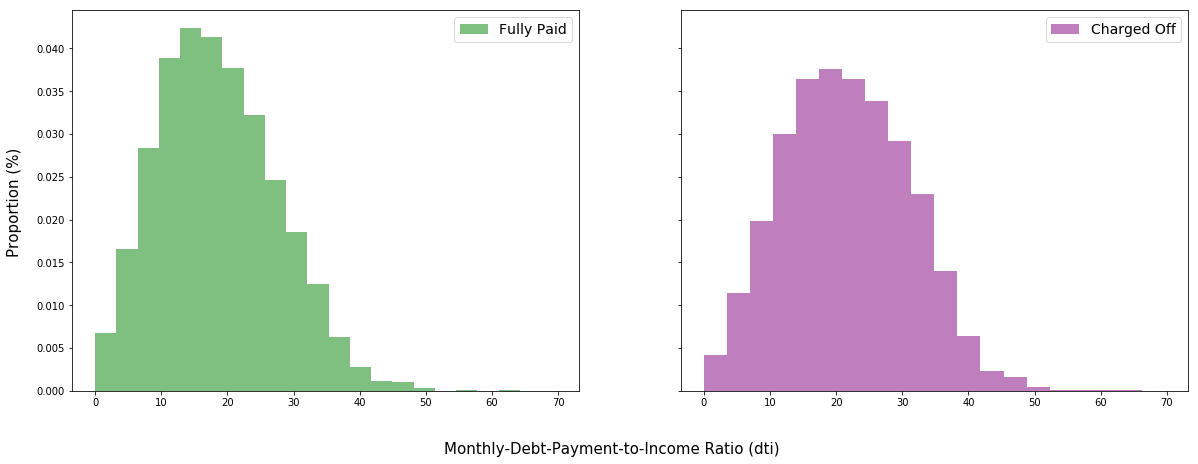

In [25]:
from collections import OrderedDict

# Extract DTI ratios below 70 for plotting (i.e. the vast majority)
fpdti = fp.iloc[:]['dti'].dropna()
fpdti = fpdti[fpdti<70]
cfdti = cf.iloc[:]['dti'].dropna()
cfdti = cfdti[cfdti<70]

# Plot
f, sp = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20,7))

sp[0].hist(fpdti, color = 'g', alpha = 0.5,bins=20,density=True)
sp[0].legend(['Fully Paid'],prop={'size': 14})
sp[1].hist(cfdti, color = 'purple', alpha=0.5,bins=20,density=True)
sp[1].legend(['Charged Off'],prop={'size': 14})

f.text(0.5, 0, 'Monthly-Debt-Payment-to-Income Ratio (dti)', ha='center',size=15)
f.text(0.08, 0.5, 'Proportion (%)', va='center', rotation='vertical',size=15)

plt.show()

In [62]:
np.mean(fpdti), np.mean(cfdti)

(18.57223773075185, 21.657858894170648)

Intuition suggests that borrowers with lower debt as a percentage of income are more likely to make good on their loans than borrowers with a higher debt as a percentage of income. Thus, it does make sense that the distribution of `charged off` applicants is centered slightly to the right of that of `fully paid` applicants. The mean DTI of `fully paid` applicants is 18.57$\%$, whereas that of `charged off` applicants is 21.65$\%$.

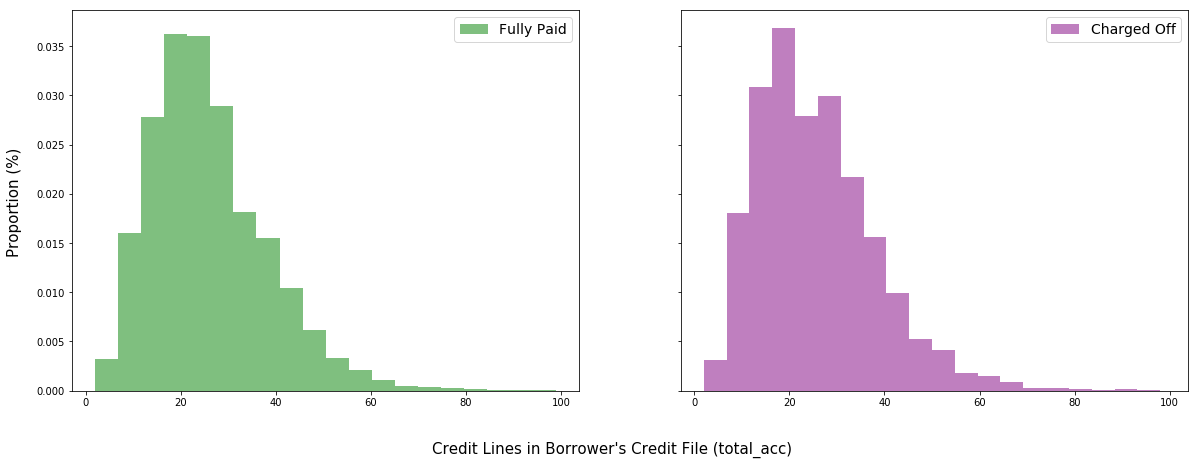

In [26]:
# Extract total number of credit lines currently in the borrower's credit file
fpta = fp.iloc[:]['total_acc'].dropna()
fpta = fpta[fpta<100]
cfta = cf.iloc[:]['total_acc'].dropna()
cfta = cfta[cfta<100]

# Plot
f, sp = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20,7))

sp[0].hist(fpta, color = 'g', alpha = 0.5,bins=20,density=True)
sp[0].legend(['Fully Paid'],prop={'size': 14})
sp[1].hist(cfta, color = 'purple', alpha=0.5,bins=20,density=True)
sp[1].legend(['Charged Off'],prop={'size': 14})
    
f.text(0.5, 0, "Credit Lines in Borrower's Credit File (total_acc)", ha='center',size=15)
f.text(0.08, 0.5, 'Proportion (%)', va='center', rotation='vertical',size=15)

plt.show()

We had two possible hypotheses about the relationship between credit lines and repayment prospects for a borrower. On one hand, having more credit lines suggests that a borrower may currently carry a greater debt burden or carry an even greater one in the future, thereby impairing his ability to make payments. On the other hand, a borrower with more credit lines demonstrates that other institutions and individuals are willing to offer him credit, thereby signalling his credit-worthiness. Furthermore, this borrower will be able to refinance more conveniently than comparable borrowers with fewer credit lines.

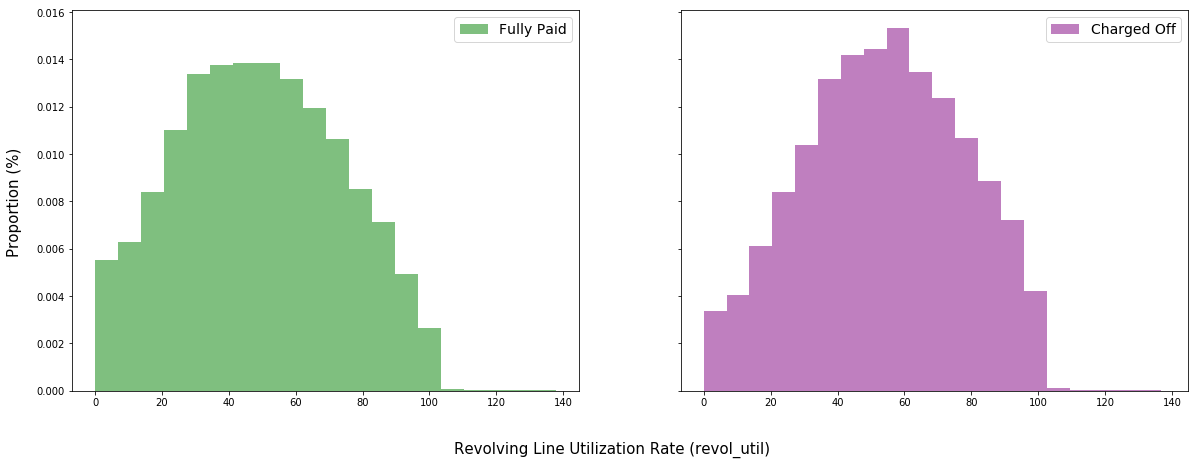

In [27]:
# Total credit revolving balance
fpru = fp.iloc[:]['revol_util'].astype(float)
# fprb = fprb[fprb<200000]
cfru = cf.iloc[:]['revol_util'].astype(float)
# cfrb = cfrb[cfrb<200000]

# Plot
f, sp = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20,7))

sp[0].hist(fpru, color = 'g', alpha = 0.5,bins=20,density=True)
sp[0].legend(['Fully Paid'],prop={'size': 14})
sp[1].hist(cfru, color = 'purple', alpha=0.5,bins=20,density=True)
sp[1].legend(['Charged Off'],prop={'size': 14})

f.text(0.5, 0, "Revolving Line Utilization Rate (revol_util)", ha='center',size=15)
f.text(0.08, 0.5, 'Proportion (%)', va='center', rotation='vertical',size=15)

plt.show()

In [63]:
np.mean(fpru), np.mean(cfru)

(48.9725650000003, 53.88610499999992)

Lending club defines "revolving line utilization rate" as the amount of credit the borrower is using relative to all available revolving credit.

Investors might invoke similar logic as to that used in the discussion on credit lines above. However, in this plot, we gain a better sense of how much of available credit borrowers under either class was using before they fully paid their loans or stopped making payments. Naturally, one would expect borrowers with greater overall debt burdens to struggle more to make payments than those with lower burdens.

Indeed, the utilization rate is 48.97$\%$ for `fully paid` borrowers and 53.89$\%$ for `charged off` borrowers.

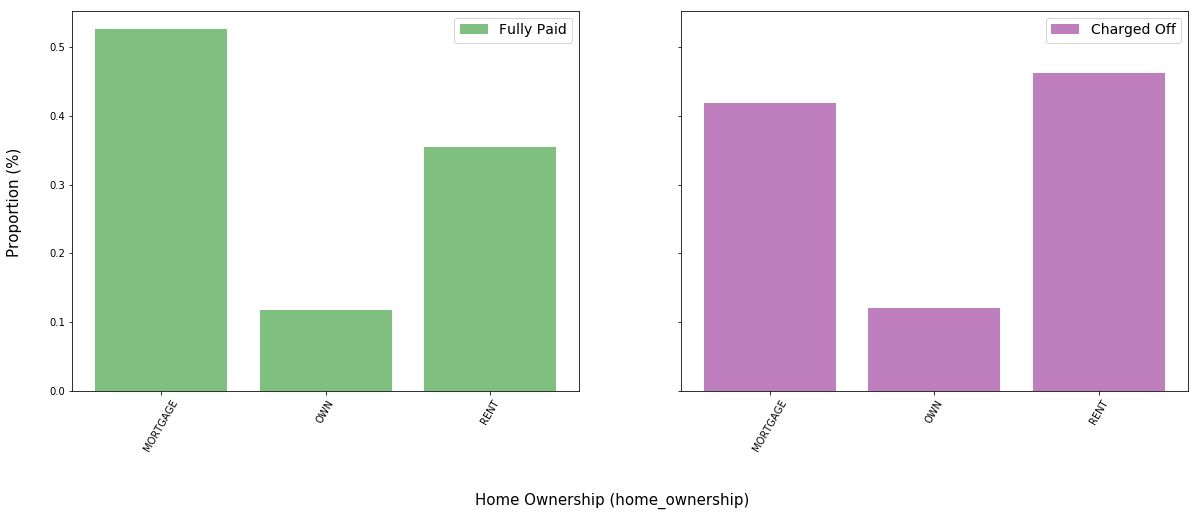

In [71]:
fphome = fp.iloc[:,8]
cfhome = cf.iloc[:,8]

dict_fphome = fphome.value_counts()
keys_fphome = sorted(dict_fphome.keys())
dict_fphome = OrderedDict((key,dict_fphome[key]) for key in keys_fphome)
dict_fphome.update((x, y/20000) for x, y in dict_fphome.items())

dict_cfhome = cfhome.value_counts()
keys_cfhome = sorted(dict_cfhome.keys())
dict_cfhome = OrderedDict((key,dict_cfhome[key]) for key in keys_cfhome)
dict_cfhome.update((x, y/20000) for x, y in dict_cfhome.items())

# Plot
f, sp = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20,7))

sp[0].bar(dict_fphome.keys(), dict_fphome.values(), color = 'g', alpha = 0.5)
sp[0].legend(['Fully Paid'],prop={'size': 14})
sp[1].bar(dict_cfhome.keys(), dict_cfhome.values(), color = 'purple', alpha=0.5)
sp[1].legend(['Charged Off'],prop={'size': 14})

for tick in sp[0].get_xticklabels():
    tick.set_rotation(60)
for tick in sp[1].get_xticklabels():
    tick.set_rotation(60)
    
f.text(0.5, -0.1, 'Home Ownership (home_ownership)', ha='center',size=15)
f.text(0.08, 0.5, 'Proportion (%)', va='center', rotation='vertical',size=15)

plt.show()

In [73]:
dict_fphome.keys(), dict_fphome.values(), dict_cfhome.keys(), dict_cfhome.values()

(odict_keys(['MORTGAGE', 'OWN', 'RENT']),
 odict_values([0.5262, 0.11855, 0.35525]),
 odict_keys(['MORTGAGE', 'OWN', 'RENT']),
 odict_values([0.41795, 0.12065, 0.4614]))

The data suggests that mortgages are positively correlated with loan repayment and renting is negatively correlated with loan repayment. It is possible that those with mortgages have more experience with borrowing and paying back debt in general. 

Approximately 52.62$\%$ of `fully paid` applicants borrowed through a mortgage, compared to 41.8$\%$ of `charged off` applicants. 

Conversely, approximately 35.53$\%$ of `fully paid` applicants rented, compared to 46.14$\%$ of `charged off` applicants.

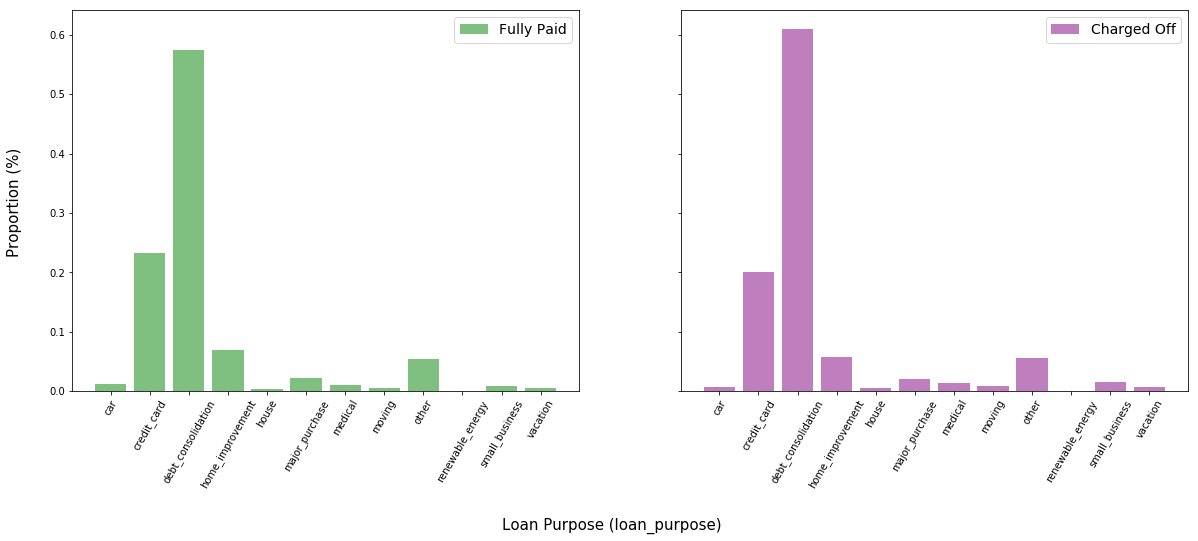

In [30]:
fppurp = fp.iloc[:,12]
cfpurp = cf.iloc[:,12]

dict_fppurp = fppurp.value_counts()
keys_fppurp = sorted(dict_fppurp.keys())
dict_fppurp = OrderedDict((key,dict_fppurp[key]) for key in keys_fppurp)
dict_fppurp.update((x, y/20000) for x, y in dict_fppurp.items())

dict_cfpurp = cfpurp.value_counts()
keys_cfpurp = sorted(dict_cfpurp.keys())
dict_cfpurp = OrderedDict((key,dict_cfpurp[key]) for key in keys_cfpurp)
dict_cfpurp.update((x, y/20000) for x, y in dict_cfpurp.items())

# Plot
f, sp = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20,7))

sp[0].bar(dict_fppurp.keys(), dict_fppurp.values(), color = 'g', alpha = 0.5)
sp[0].legend(['Fully Paid'],prop={'size': 14})
sp[1].bar(dict_cfpurp.keys(), dict_cfpurp.values(), color = 'purple', alpha=0.5)
sp[1].legend(['Charged Off'],prop={'size': 14})
    
for tick in sp[0].get_xticklabels():
    tick.set_rotation(60)
for tick in sp[1].get_xticklabels():
    tick.set_rotation(60)
    
f.text(0.5, -0.15, 'Loan Purpose (loan_purpose)', ha='center',size=15)
f.text(0.08, 0.5, 'Proportion (%)', va='center', rotation='vertical',size=15)

plt.show()

Surprisingly, there does not seem to be a substantial difference in the loan purpose between the two classes. 

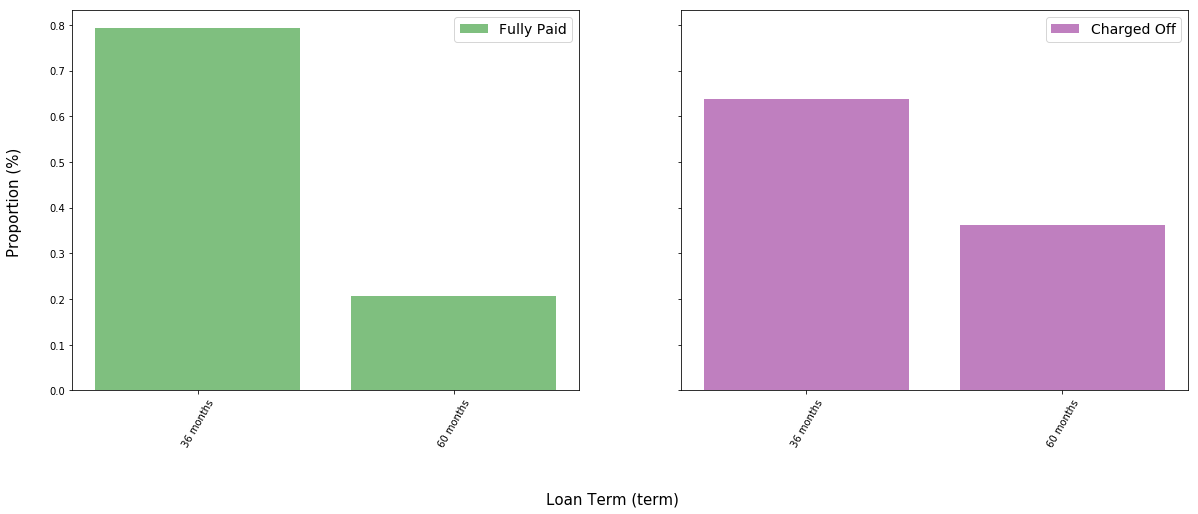

In [70]:
fpterm = fp.iloc[:,3]
cfterm = cf.iloc[:,3]

dict_fpterm = fpterm.value_counts()
keys_fpterm = sorted(dict_fpterm.keys())
dict_fpterm = OrderedDict((key,dict_fpterm[key]) for key in keys_fpterm)
dict_fpterm.update((x, y/20000) for x, y in dict_fpterm.items())

dict_cfterm = cfterm.value_counts()
keys_cfterm = sorted(dict_cfterm.keys())
dict_cfterm = OrderedDict((key,dict_cfterm[key]) for key in keys_cfterm)
dict_cfterm.update((x, y/20000) for x, y in dict_cfterm.items())

# Plot
f, sp = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20,7))

sp[0].bar(dict_fpterm.keys(), dict_fpterm.values(), color = 'g', alpha = 0.5)
sp[0].legend(['Fully Paid'],prop={'size': 14})
sp[1].bar(dict_cfterm.keys(), dict_cfterm.values(), color = 'purple', alpha=0.5)
sp[1].legend(['Charged Off'],prop={'size': 14})

for tick in sp[0].get_xticklabels():
    tick.set_rotation(60)
for tick in sp[1].get_xticklabels():
    tick.set_rotation(60)
    
f.text(0.5, -0.1, 'Loan Term (term)', ha='center',size=15)
f.text(0.08, 0.5, 'Proportion (%)', va='center', rotation='vertical',size=15)

plt.show()

Applicants taking longer term loans appear significantly more likely to have their loans `charged off`. Perhaps there is a selection bias; some individuals who cannot afford to borrow significant amounts may take out longer loans hoping that they will eventually gather the money to pay back the principal.

There is the additional influence of longer-term loans requiring a larger gross sum of interest payment, ceteris paribus, than shorter-term loans. This may result in cash-strapped individuals having less money in the future to repay their principals.

# (3) Race-Based Statistical Discrimination Analysis

In [144]:
# List of subgrades
subgrades = list(set(df['sub_grade']))

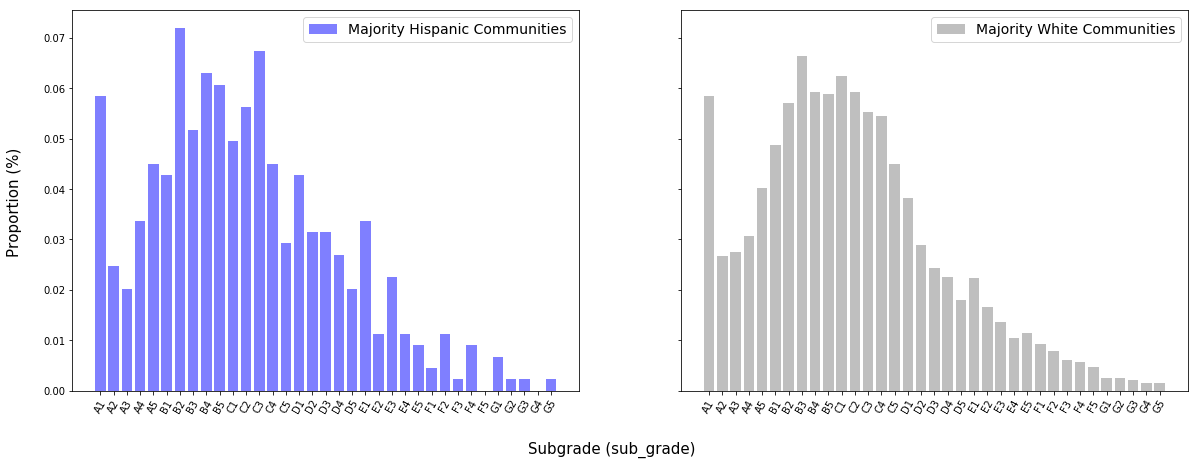

In [145]:
# Extract majority hispanic and white zip codes and respective rows in LC database
mhz = list(race[race['Hispanic Proportion'] > 50]['Zip Code'])
mhsg = master[master['zip_code'].isin(mhz)]['sub_grade']

mwz = list(race[race['White Proportion'] > 50]['Zip Code'])
mwsg = master[master['zip_code'].isin(mwz)]['sub_grade']

dict_mhsg = mhsg.value_counts()

for i in range(0,len(subgrades)):
    if subgrades[i] in dict_mhsg.keys():
        continue
    else:
        dict_mhsg[subgrades[i]] = 0
        
keys_mhsg = sorted(dict_mhsg.keys())
dict_mhsg = OrderedDict((key,dict_mhsg[key]) for key in keys_mhsg)
dict_mhsg.update((x, y/len(mhsg)) for x, y in dict_mhsg.items())

dict_mwsg = mwsg.value_counts()
keys_mwsg = sorted(dict_mwsg.keys())
dict_mwsg = OrderedDict((key,dict_mwsg[key]) for key in keys_mwsg)
dict_mwsg.update((x, y/len(mwsg)) for x, y in dict_mwsg.items())

# Plot
f, sp = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20,7))

sp[0].bar(dict_mhsg.keys(), dict_mhsg.values(), color = 'blue', alpha = 0.5)
sp[0].legend(['Majority Hispanic Communities'],prop={'size': 14})
sp[1].bar(dict_mwsg.keys(), dict_mwsg.values(), color = 'grey', alpha=0.5)
sp[1].legend(['Majority White Communities'],prop={'size': 14})
    
for tick in sp[0].get_xticklabels():
    tick.set_rotation(60)
for tick in sp[1].get_xticklabels():
    tick.set_rotation(60)
    
f.text(0.5, 0, 'Subgrade (sub_grade)', ha='center',size=15)
f.text(0.08, 0.5, 'Proportion (%)', va='center', rotation='vertical',size=15)

plt.show()

Majority Hispanic communities are defined here as those where the proportion of individuals identifying as Hispanic exceeds 50$\%$. Majority White communities are defined similarly.

The distributions of subgrades for the two groups are very similar. This may be in part due to the fact that the census dataset does not consider the proportion of white individuals in a community as mutually exclusive from the proportion of Hispanic individuals. "White" and "black," however, are considered mutually exclusive.

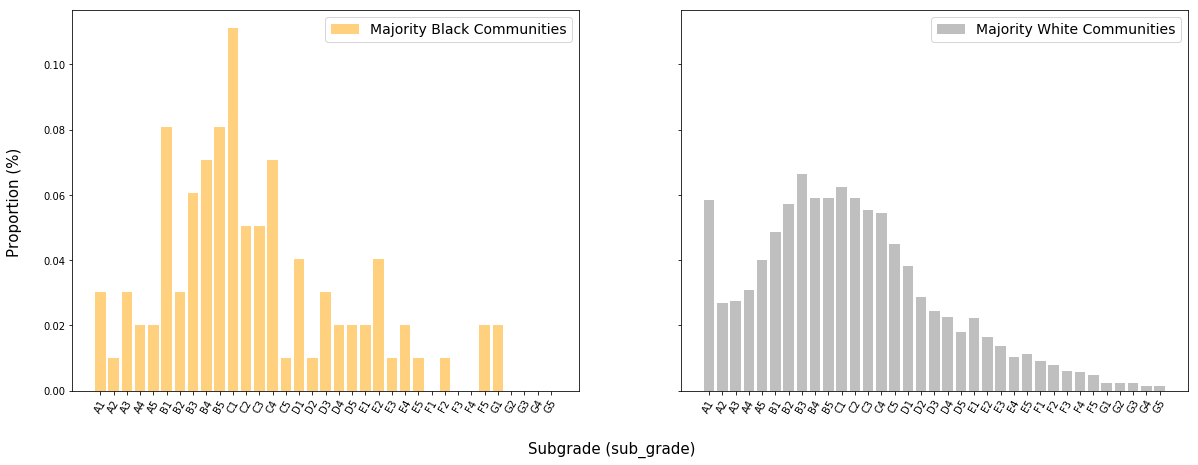

In [146]:
# Extract majority black and white zip codes and respective rows in LC database
mbz = list(race[race['Black Proportion'] > 50]['Zip Code'])
mbsg = master[master['zip_code'].isin(mbz)]['sub_grade']

dict_mbsg = mbsg.value_counts()

for i in range(0,len(subgrades)):
    if subgrades[i] in dict_mbsg.keys():
        continue
    else:
        dict_mbsg[subgrades[i]] = 0

keys_mbsg = sorted(dict_mbsg.keys())
dict_mbsg = OrderedDict((key,dict_mbsg[key]) for key in keys_mbsg)
dict_mbsg.update((x, y/len(mbsg)) for x, y in dict_mbsg.items())

# Plot
f, sp = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20,7))

sp[0].bar(dict_mbsg.keys(), dict_mbsg.values(), color = 'orange', alpha = 0.5)
sp[0].legend(['Majority Black Communities'],prop={'size': 14})
sp[1].bar(dict_mwsg.keys(), dict_mwsg.values(), color = 'grey', alpha=0.5)
sp[1].legend(['Majority White Communities'],prop={'size': 14})
    
for tick in sp[0].get_xticklabels():
    tick.set_rotation(60)
for tick in sp[1].get_xticklabels():
    tick.set_rotation(60)
    
f.text(0.5, 0, 'Subgrade (sub_grade)', ha='center',size=15)
f.text(0.08, 0.5, 'Proportion (%)', va='center', rotation='vertical',size=15)

plt.show()

The distribution of subgrades for borrowers from majority-black communities has skinnier tails than the distribution for majority-white communities, though both distributions appear to be roughly centered between `B` and `C` ratings.

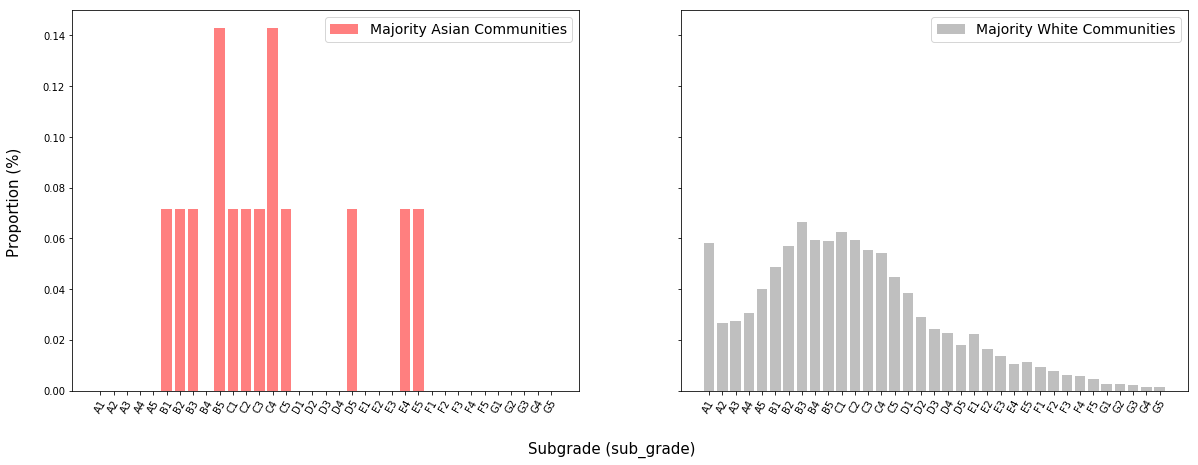

In [153]:
# Extract majority Asian and white zip codes and respective rows in LC database
maz = list(race[race['Asian Proportion'] > 50]['Zip Code'])
masg = master[master['zip_code'].isin(maz)]['sub_grade']

dict_masg = masg.value_counts()

for i in range(0,len(subgrades)):
    if subgrades[i] in dict_masg.keys():
        continue
    else:
        dict_masg[subgrades[i]] = 0

keys_masg = sorted(dict_masg.keys())
dict_masg = OrderedDict((key,dict_masg[key]) for key in keys_masg)
dict_masg.update((x, y/len(masg)) for x, y in dict_masg.items())

# Plot
f, sp = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20,7))

sp[0].bar(dict_masg.keys(), dict_masg.values(), color = 'red', alpha = 0.5)
sp[0].legend(['Majority Asian Communities'],prop={'size': 14})
sp[1].bar(dict_mwsg.keys(), dict_mwsg.values(), color = 'grey', alpha=0.5)
sp[1].legend(['Majority White Communities'],prop={'size': 14})
    
for tick in sp[0].get_xticklabels():
    tick.set_rotation(60)
for tick in sp[1].get_xticklabels():
    tick.set_rotation(60)
    
f.text(0.5, 0, 'Subgrade (sub_grade)', ha='center',size=15)
f.text(0.08, 0.5, 'Proportion (%)', va='center', rotation='vertical',size=15)

plt.show()

There are not a sufficient amount of data points in the distribution of applicants from majority-Asian communities (there are only two such communities), but it appears that the distribution is centered in more or less the same place as that of applicants from majority-white communities.

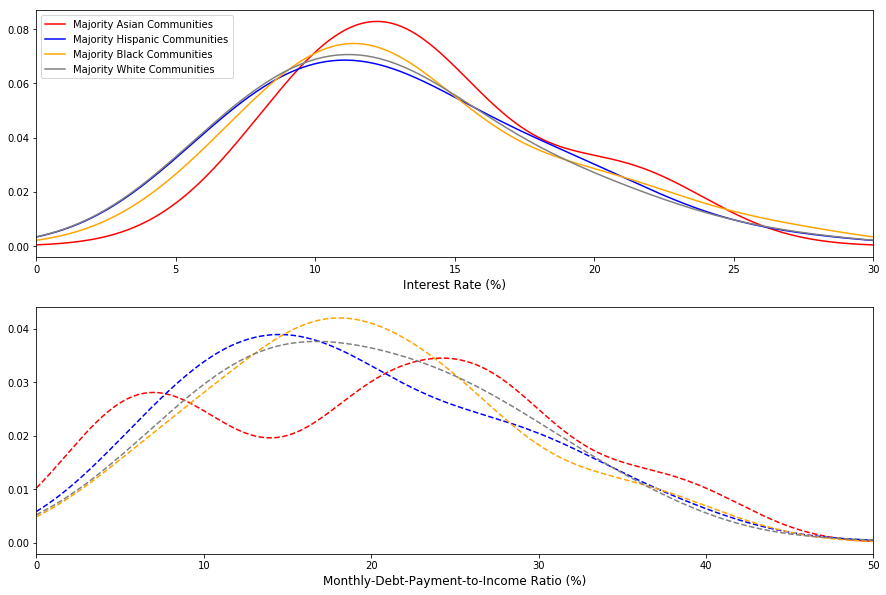

In [191]:
from sklearn.neighbors.kde import KernelDensity

# Get majority rows
maj_asian_df = master[master['zip_code'].isin(maz)]
maj_hisp_df = master[master['zip_code'].isin(mhz)]
maj_black_df = master[master['zip_code'].isin(mbz)]
maj_white_df = master[master['zip_code'].isin(mwz)]

# Pull interest rates by race and fit KDE's
X_asian = (np.array(maj_asian_df['int_rate'])*100).reshape(-1,1)
kde_asian = KernelDensity(kernel='gaussian', bandwidth=3).fit(X_asian)

X_hispanic = (np.array(maj_hisp_df['int_rate'])*100).reshape(-1,1)
kde_hispanic = KernelDensity(kernel='gaussian', bandwidth=3).fit(X_hispanic)

X_black = (np.array(maj_black_df['int_rate'])*100).reshape(-1,1)
kde_black = KernelDensity(kernel='gaussian', bandwidth=3).fit(X_black)

X_white = (np.array(maj_white_df['int_rate'])*100).reshape(-1,1)
kde_white = KernelDensity(kernel='gaussian', bandwidth=3).fit(X_white)

X_plot = np.linspace(0, 50, 1000)[:, np.newaxis]
log_dens_asian = kde_asian.score_samples(X_plot)
log_dens_hispanic = kde_hispanic.score_samples(X_plot)
log_dens_black = kde_black.score_samples(X_plot)
log_dens_white = kde_white.score_samples(X_plot)

# Pull DTI ratios by race and fit KDE's
X_asian_dti = (np.array(maj_asian_df['dti']))
X_asian_dti = X_asian_dti[~np.isnan(X_asian_dti)].reshape(-1,1)
kde_asian_dti = KernelDensity(kernel='gaussian', bandwidth=4).fit(X_asian_dti)

X_hispanic_dti = (np.array(maj_hisp_df['dti']))
X_hispanic_dti = X_hispanic_dti[~np.isnan(X_hispanic_dti)].reshape(-1,1)
kde_hispanic_dti = KernelDensity(kernel='gaussian', bandwidth=4).fit(X_hispanic_dti)

X_black_dti = (np.array(maj_black_df['dti']))
X_black_dti = X_black_dti[~np.isnan(X_black_dti)].reshape(-1,1)
kde_black_dti = KernelDensity(kernel='gaussian', bandwidth=4).fit(X_black_dti)

X_white_dti = (np.array(maj_white_df['dti']))
X_white_dti = X_white_dti[~np.isnan(X_white_dti)].reshape(-1,1)
kde_white_dti = KernelDensity(kernel='gaussian', bandwidth=4).fit(X_white_dti)

X_plot_2 = np.linspace(0, 70, 5000)[:, np.newaxis]
log_dens_asian_dti = kde_asian_dti.score_samples(X_plot_2)
log_dens_hispanic_dti = kde_hispanic_dti.score_samples(X_plot_2)
log_dens_black_dti = kde_black_dti.score_samples(X_plot_2)
log_dens_white_dti = kde_white_dti.score_samples(X_plot_2)

# Plot KDE's
f, (ax1,ax2) = plt.subplots(2, 1, figsize=(15,10))

# Interest Rates Plot
ax1.plot(X_plot[:, 0], np.exp(log_dens_asian), '-', color = 'red')
ax1.plot(X_plot[:, 0], np.exp(log_dens_hispanic), '-', color = 'blue')
ax1.plot(X_plot[:, 0], np.exp(log_dens_black), '-', color = 'orange')
ax1.plot(X_plot[:, 0], np.exp(log_dens_white), '-', color = 'grey')
ax1.set_xlabel("Interest Rate (%)",size=12)
ax1.set_xlim(0, 30)
ax1.legend(['Majority Asian Communities','Majority Hispanic Communities',
            'Majority Black Communities','Majority White Communities'],loc='upper left')


# DTI Ratio Plot
ax2.plot(X_plot_2[:, 0], np.exp(log_dens_asian_dti), '--', color = 'red')
ax2.plot(X_plot_2[:, 0], np.exp(log_dens_hispanic_dti), '--', color = 'blue')
ax2.plot(X_plot_2[:, 0], np.exp(log_dens_black_dti), '--', color = 'orange')
ax2.plot(X_plot_2[:, 0], np.exp(log_dens_white_dti), '--', color = 'grey')
ax2.set_xlabel("Monthly-Debt-Payment-to-Income Ratio (%)",size=12)
ax2.set_xlim(0, 50)

# f.text(0.5, 0.05, 'Interest Rate (%)', ha='center',size=15)
# f.text(0.06, 0.5, 'Density', va='center', rotation='vertical',size=15)

plt.show()

DTI ratios and interest rate appear to follow similar distributions across racial groups.